<a href="https://colab.research.google.com/github/Frecherenkel60/RandomForestRangers/blob/main/DataMining_RandomForestRangers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Random Forest Rangers - Predicting Car Sales Prices

In [63]:
# Install dependencies
# !pip install -r requirements.txt
import warnings
warnings.filterwarnings("ignore")

In [64]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
# from sklearn.metrics import mean_squared_error, r2_score
from sklearn import preprocessing
# from minisom import MiniSom
# from sklearn.preprocessing import MinMaxScaler

In [65]:
#dataset = pd.read_csv('./data/used_car_prices_generated.csv')
data_split_read = pd.read_csv('./data/0_Data_Split/train.csv')
dataset_pre = pd.read_csv('./data/1_Preprocessing/train.csv')
# Remove the last 3 characters (' mi') and convert to float
data_split_read['milage'] = data_split_read['milage'].str[:-3]  # Remove last 3 characters
data_split_read['milage'] = data_split_read['milage'].str.replace(',', '')  # Remove commas
data_split_read['milage'] = data_split_read['milage'].astype(float)  # Convert to float

# Merge the 'brand' column from the data_split_read dataset into after_preprocessing
data_split = dataset_pre.merge(
    data_split_read[['price', 'milage', 'brand']],
    on=['price', 'milage'],
    how='left'  # Use 'left' to retain all rows in after_preprocessing
)

print(data_split.describe())

        model_year         milage     accident  clean_title          price  \
count  3203.000000    3203.000000  3203.000000  3203.000000    3203.000000   
mean   2015.456759   65663.416485     0.278489     0.854199   40030.960662   
std       6.137523   52560.486264     0.448325     0.352962   36735.288148   
min    1974.000000     100.000000     0.000000     0.000000    2000.000000   
25%    2012.000000   23567.500000     0.000000     1.000000   17000.000000   
50%    2017.000000   54000.000000     0.000000     1.000000   31000.000000   
75%    2020.000000   95000.000000     1.000000     1.000000   48994.500000   
max    2024.000000  405000.000000     1.000000     1.000000  289991.000000   

             turbo    is_luxury  is_upper_class  engine_score  
count  3203.000000  3203.000000     3203.000000   3203.000000  
mean      0.071808     0.019045        0.110209      0.074680  
std       0.258210     0.136703        0.313199      0.581442  
min       0.000000     0.000000        0.

## Some interesting plots and insights from the data_split

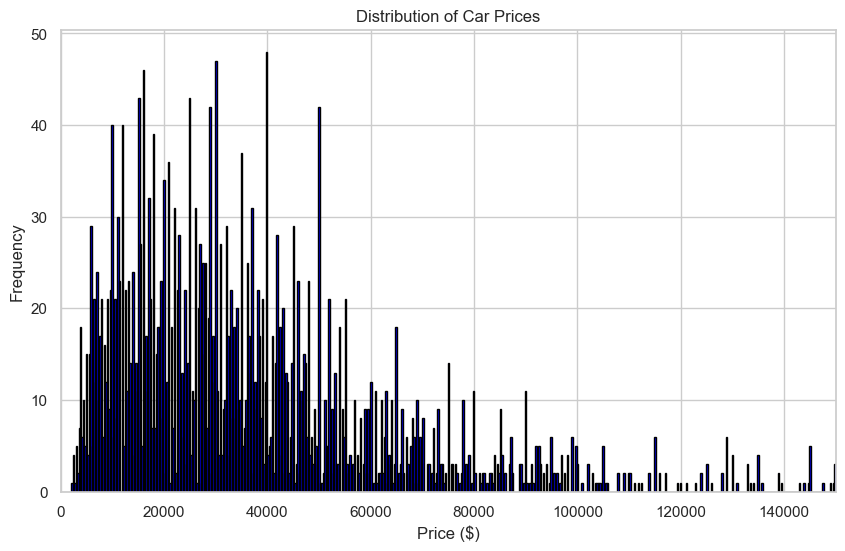

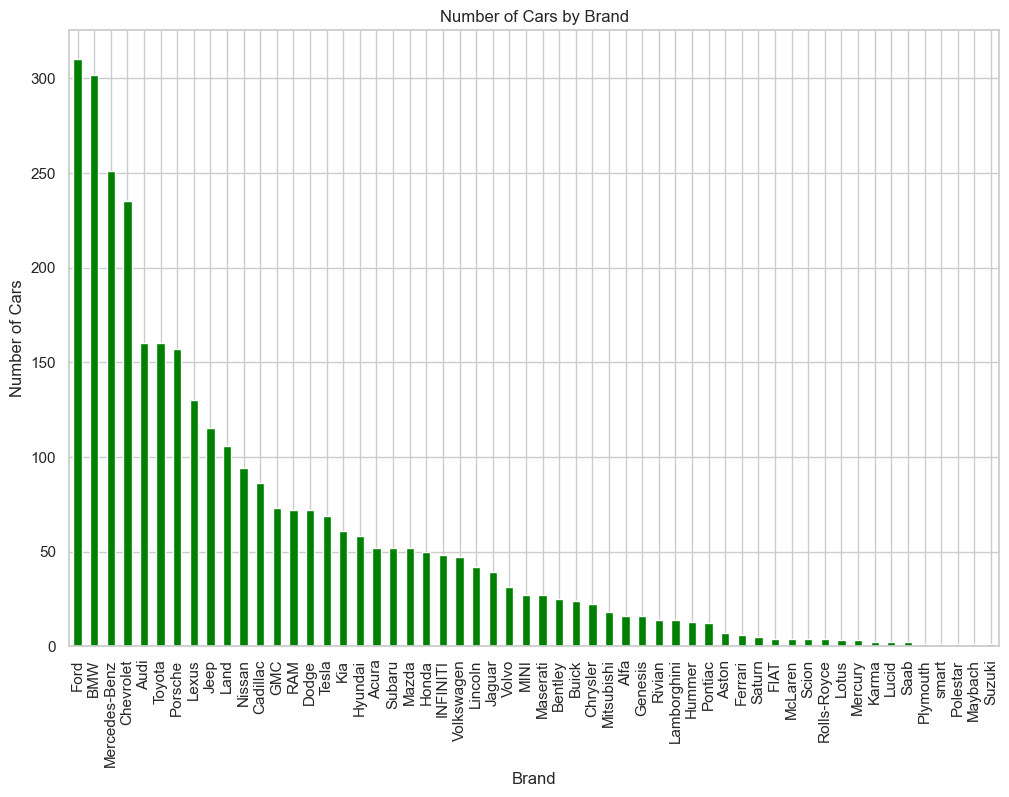

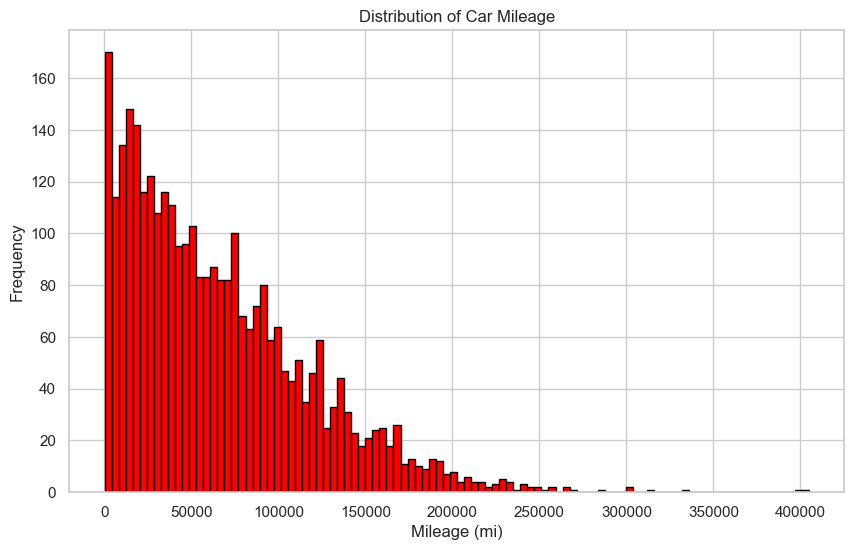

In [66]:
# Plot distribution of car prices
plt.figure(figsize=(10, 6))
plt.hist(data_split['price'].dropna(), bins=1000, color='blue', edgecolor='black')
plt.title('Distribution of Car Prices')
plt.xlabel('Price ($)')
plt.ylabel('Frequency')
plt.grid(True)
plt.xlim(0,150000)
plt.show()


# Plot number of cars by brand
plt.figure(figsize=(12, 8))
data_split['brand'].value_counts().plot(kind='bar', color='green')
plt.title('Number of Cars by Brand')
plt.xlabel('Brand')
plt.ylabel('Number of Cars')
plt.grid(True)
plt.show()

# Plot distribution of mileage
plt.figure(figsize=(10, 6))
plt.hist(data_split['milage'].dropna(), bins=100, color='red', edgecolor='black')
plt.title('Distribution of Car Mileage')
plt.xlabel('Mileage (mi)')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

data_split = data_split.copy()

# Highlevel EDA of multiple attributes thought to be essential (by domain knowledge)

## Effect of model year and/or milage on price

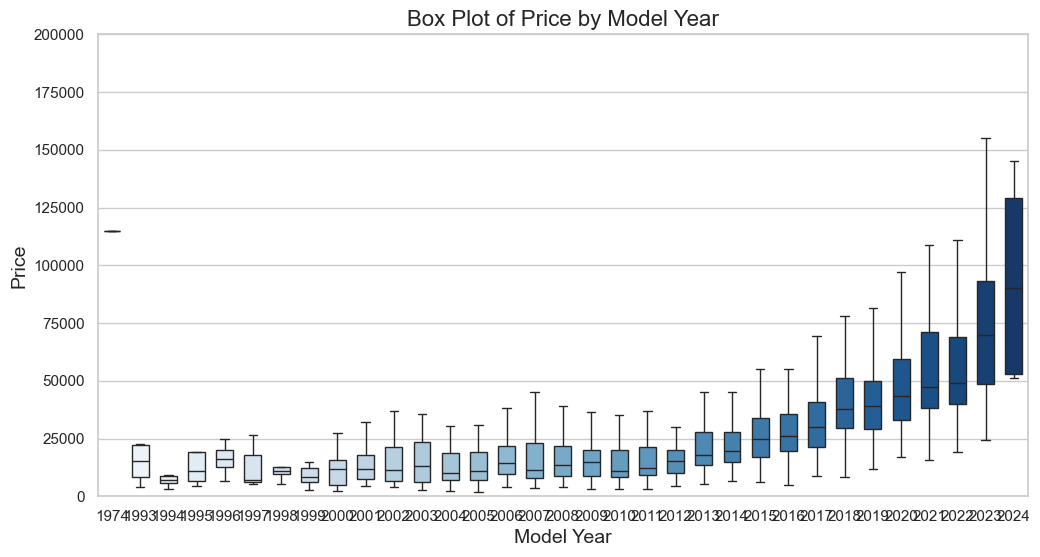

In [67]:

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='model_year', y='price', data=data_split, palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=data_split, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by Model Year', fontsize=16)
plt.xlabel('Model Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(data_split['model_year'].unique()), 5), labels=data_split['model_year'].unique()[::5])
plt.ylim(0,200000)
plt.show()




Here we can see that 1974 and 1997 are highly seperated. The distribution of the means (and in general boxplots) seems to show an exponential relationship. There is a price deep in 1998 and 1994 compared to their "neighbor years". In general the whiskers are quite wide. However, the older the vehicle, the smaller the whiskers but also smaller boxes. We can say that the prices in absolute terms are less spread the older the vehicle is. Thus, we can expect higher price prediction accuracy on older vehicles.

TODO: Hence, being able to reduce the variance of the cars or trying to find variables that explain the variance is vital.

TODO: One could think that cars before 2k are old timer. Now we will check how many data points are in those years to check if they are outliers, since their boxplot is very small.


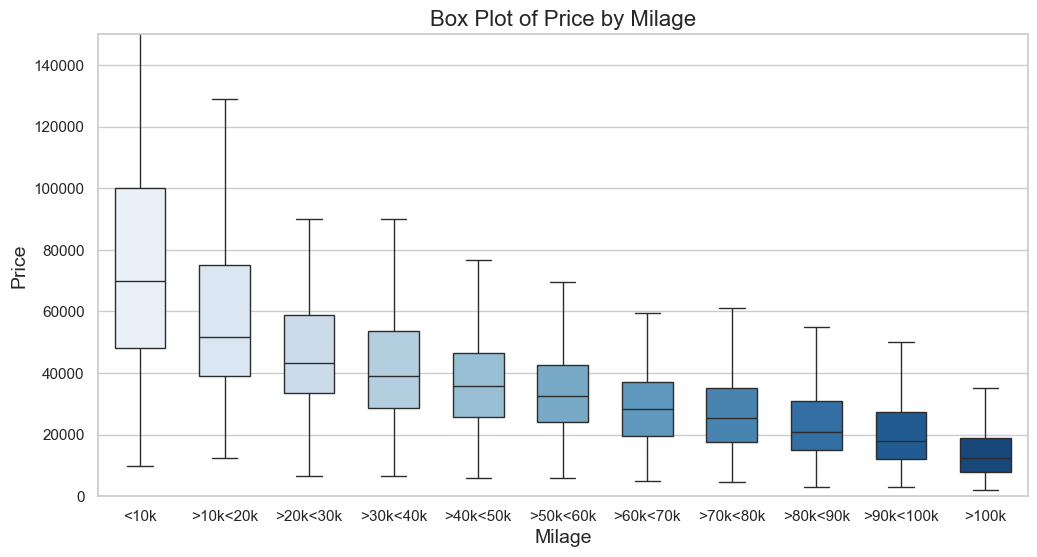

milage_Category
<10k         99962.25
>10k<20k     75000.00
>20k<30k     58824.50
>30k<40k     53699.50
>40k<50k     46599.00
>50k<60k     42624.25
>60k<70k     37000.00
>70k<80k     35000.00
>80k<90k     31000.00
>90k<100k    27499.25
>100k        18800.00
Name: price, dtype: float64


In [68]:
# Define the bins for the Mileage categories
mileage_bins = [0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000, 100000, float('inf')]
mileage_labels = ['<10k', '>10k<20k', '>20k<30k', '>30k<40k', '>40k<50k', '>50k<60k', '>60k<70k', '>70k<80k', '>80k<90k', '>90k<100k', '>100k']

# Create the Mileage categories
data_split['milage_Category'] = pd.cut(data_split['milage'], bins=mileage_bins, labels=mileage_labels, right=False)



# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='milage_Category', y='price', data=data_split, palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=data_split, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by Milage', fontsize=16)
plt.xlabel('Milage', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(data_split['model_year'].unique()), 5), labels=data_split['model_year'].unique()[::5])
plt.ylim(0,150000)
plt.show()
# Calculate the 75th percentile for price in each Mileage Category
percentile_75 = data_split.groupby('milage_Category')['price'].quantile(0.75)

# Print the 75th percentile for each category
print(percentile_75)

## Checking if attributes change in relevanz for cars newer than 2010 (based on observation of variance)

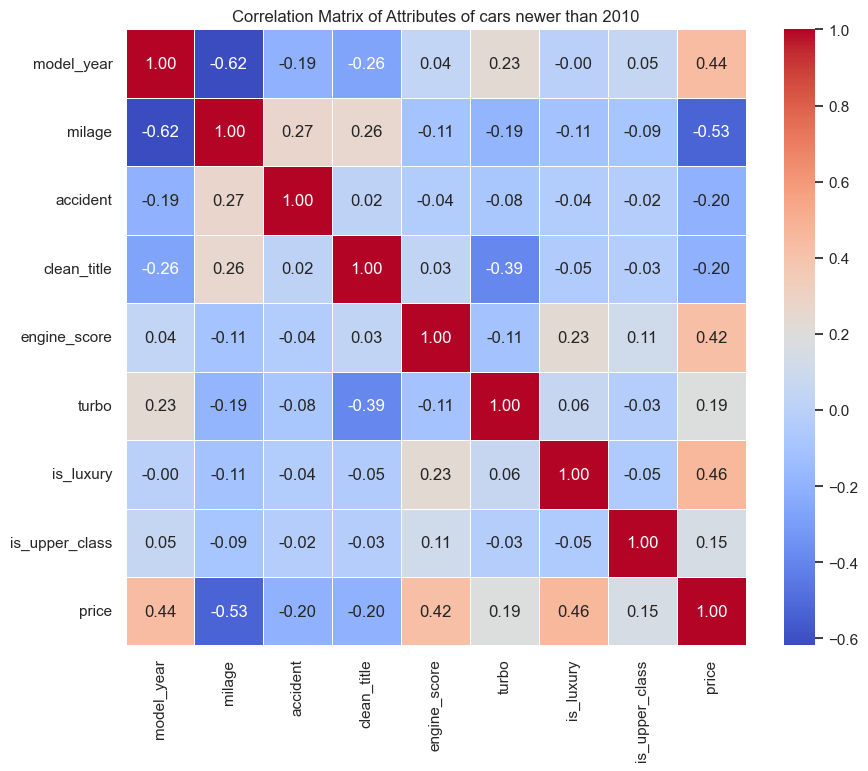

In [69]:
# Correlation matrix for cars newer than 2010
new_cars = dataset_pre.copy()

# Get the list of columns
columns = list(new_cars.columns)

# Find the indexes of the 'price' and 'engine_score' columns
price_index = columns.index('price')
engine_score_index = columns.index('engine_score')

# Swap their positions in the columns list
columns[price_index], columns[engine_score_index] = columns[engine_score_index], columns[price_index]

# Reorder the DataFrame using the modified columns list
new_cars = new_cars[columns]

corr_matrix = new_cars.corr()

# Plot heatmap of the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f', linewidths=0.5)
plt.title('Correlation Matrix of Attributes of cars newer than 2010')
plt.show()

In [70]:
# Find the lowest price for each model year
lowest_price_by_year = data_split.groupby('model_year')['price'].min().reset_index()

lowest_price_by_year
data_split.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3203 entries, 0 to 3202
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype   
---  ------           --------------  -----   
 0   model_year       3203 non-null   int64   
 1   milage           3203 non-null   float64 
 2   accident         3203 non-null   int64   
 3   clean_title      3203 non-null   int64   
 4   price            3203 non-null   int64   
 5   turbo            3203 non-null   int64   
 6   is_luxury        3203 non-null   int64   
 7   is_upper_class   3203 non-null   int64   
 8   engine_score     3203 non-null   float64 
 9   brand            3203 non-null   object  
 10  milage_Category  3203 non-null   category
dtypes: category(1), float64(2), int64(7), object(1)
memory usage: 253.9+ KB


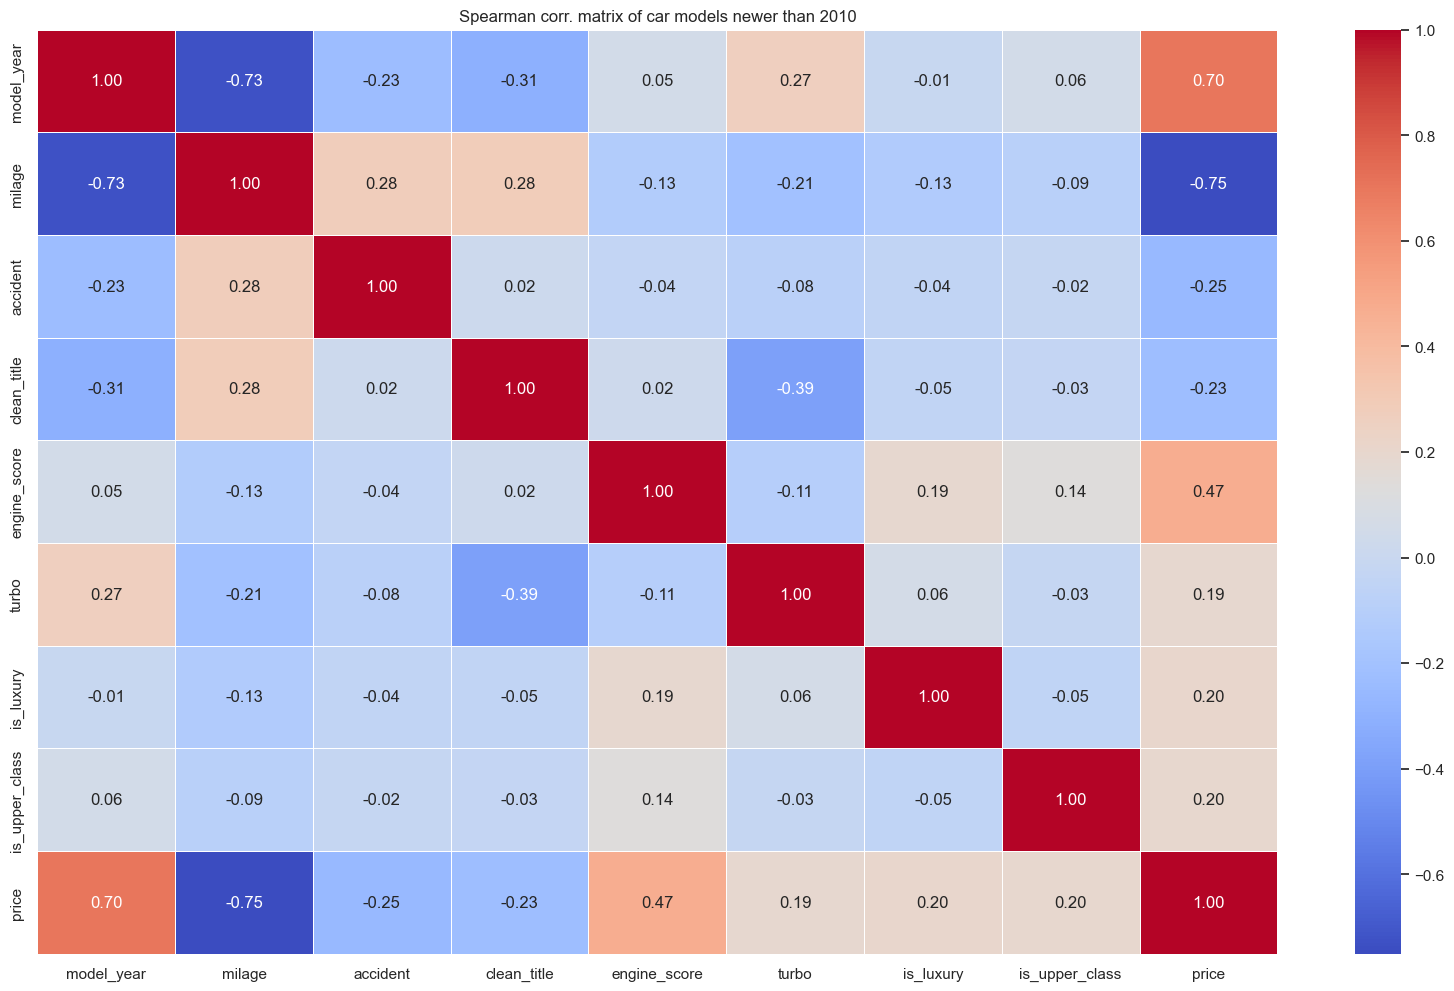

In [71]:
#Spearman alle 
corr = new_cars.corr(method = 'spearman')
plt.figure(figsize=(20, 12))
sns.heatmap(corr, annot = True, cmap = 'coolwarm', fmt = '.2f', linewidths = 0.5)
plt.title("Spearman corr. matrix of car models newer than 2010")
plt.show()

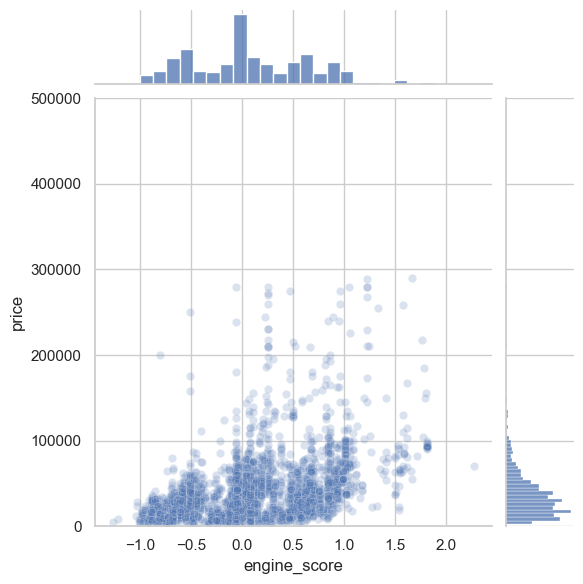

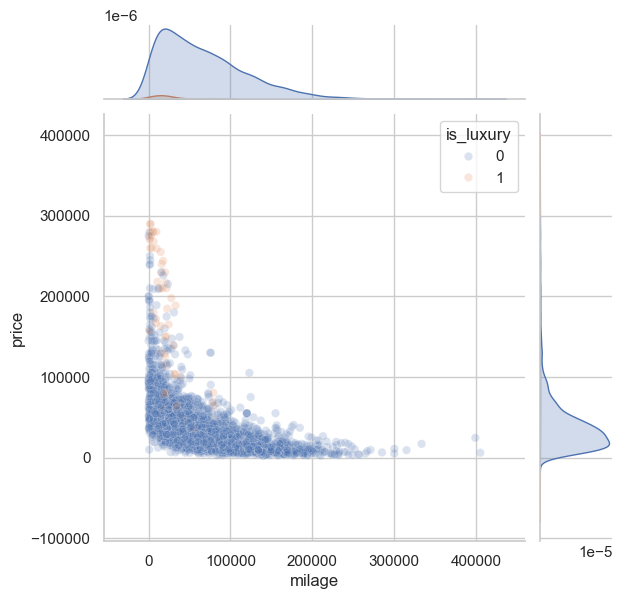

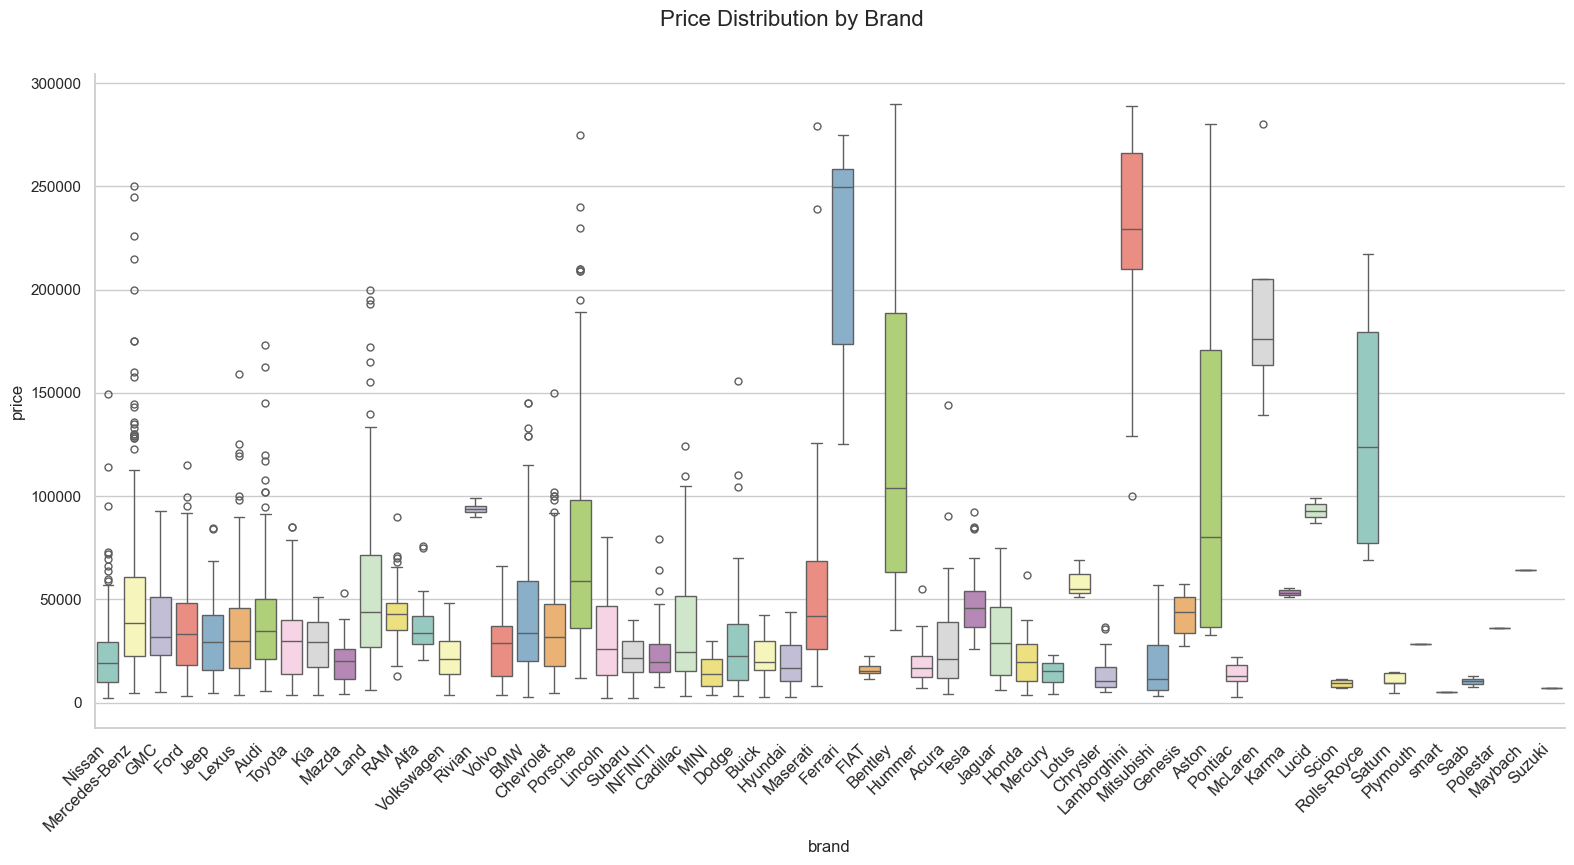

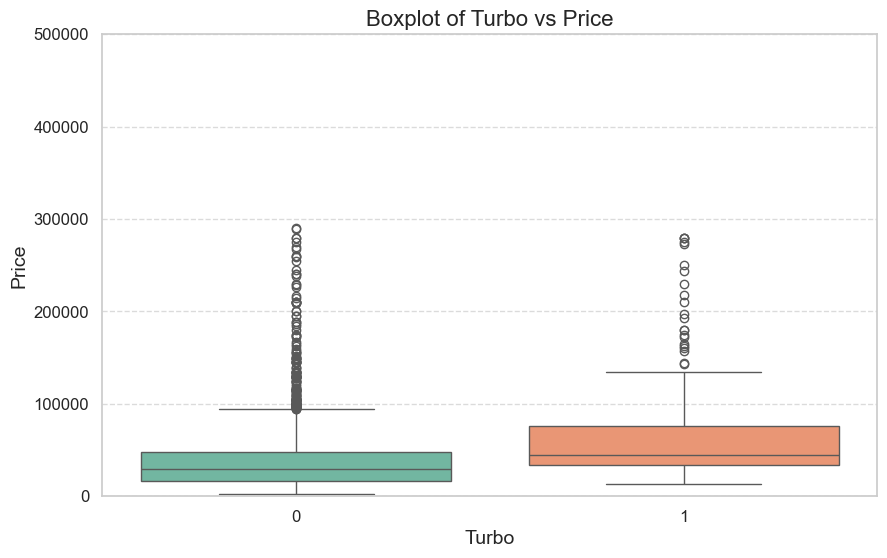

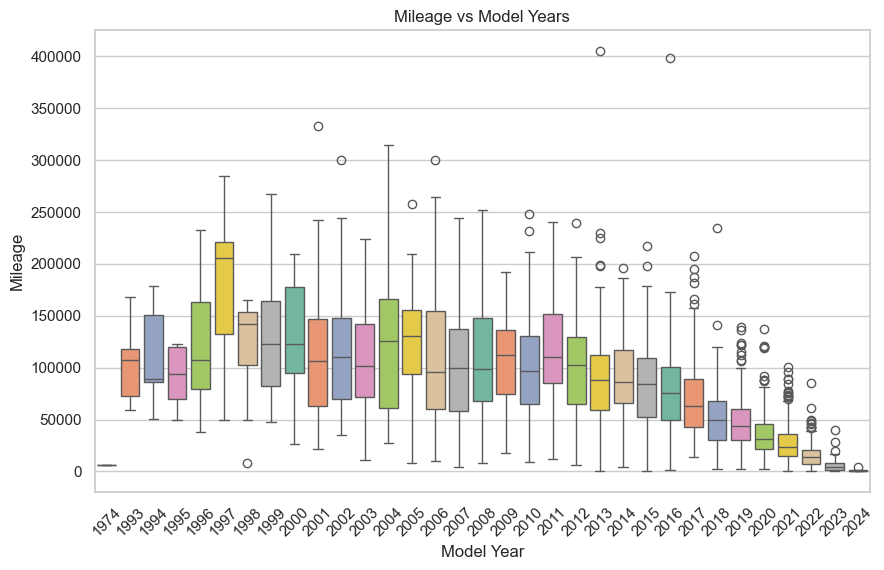

In [72]:
sns.jointplot(x="engine_score", y="price", data=data_split, alpha=0.2, ylim= (0,500000))
# Assuming 'is_luxury' is a categorical variable indicating luxury status
sns.jointplot(
    x="milage",
    y="price",
    data=data_split,
    alpha=0.2,
    hue="is_luxury",  # Color points based on 'is_luxury'
)

plt.show()

# Use catplot to visualize brand vs price
sns.set_theme(style="whitegrid")
g = sns.catplot(
    data=data_split, 
    x="brand", y="price", 
    kind="box", 
    height=8, aspect=2,  # Adjust height and aspect ratio
    palette="Set3"
)

# Rotate x-axis labels for readability
g.set_xticklabels(rotation=45, ha="right", fontsize=12)

# Enhance the plot
g.fig.subplots_adjust(top=0.9)  # Adjust top space for title
g.fig.suptitle("Price Distribution by Brand", fontsize=16)
plt.show()
# Boxplot of turbo vs price
plt.figure(figsize=(10, 6))
sns.boxplot(x="turbo", y="price", data=data_split, palette="Set2")

# Enhance the plot
plt.title("Boxplot of Turbo vs Price", fontsize=16)
plt.xlabel("Turbo", fontsize=14)
plt.ylabel("Price", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0,500000)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

# Filter to show only every 5th year
filtered_data = data_split

# Boxplot with fewer years
plt.figure(figsize=(10, 6))
sns.boxplot(x="model_year", y="milage", data=filtered_data, palette="Set2")

# Rotate x-axis labels
plt.xticks(rotation=45)
plt.title("Mileage vs Model Years")
plt.xlabel("Model Year")
plt.ylabel("Mileage")

plt.show()


We can see that there are a lot of potential outliers when determining the price of a car based on its brand. It seems like some brands are usually more expensive than others like Aston, Bentley, Porsche, Lambourghini, Ferrrari, MCLaren and Rolse-Royce. Mercedes-Benz has plenty of cars that are priced high which are indicated as pot outliers. However, MB has a wide portfolio, from afforable to luxury cars. Interestingly, Maserati isnt part of the higher priced cars. In gerneral, we can see that brands that (mainly) offer luxury products are higher priced. TODO: Potentially we can use this as an attribute in feature engineering.
Furthermore, we find that  cars are usually more expensive when they have a turbo. However, these also have plenty of pot. outliers. TODO: It would be interesting to see what attribues make the cars be outliers.
We can also see an unusual spike in amount of cars and price at the 300 engine_score mark. It reminds of a steep normal distribution. engine_score has a positive relationship with price, however, the variance is large, indicating there are more important variables to be considered (in parallel). After the 300 HP mark, the variance of HP-price significantly increases. Indicating that there are other attributes that are more important at that point.
It seems like the hypothesis regarding the increase in variance of price since 2010 is true: The Median decreases, whereby in earlier years it stays steady or goes up

# Examining the differnece luxury cars make in prices -> Creating appropriate attributes

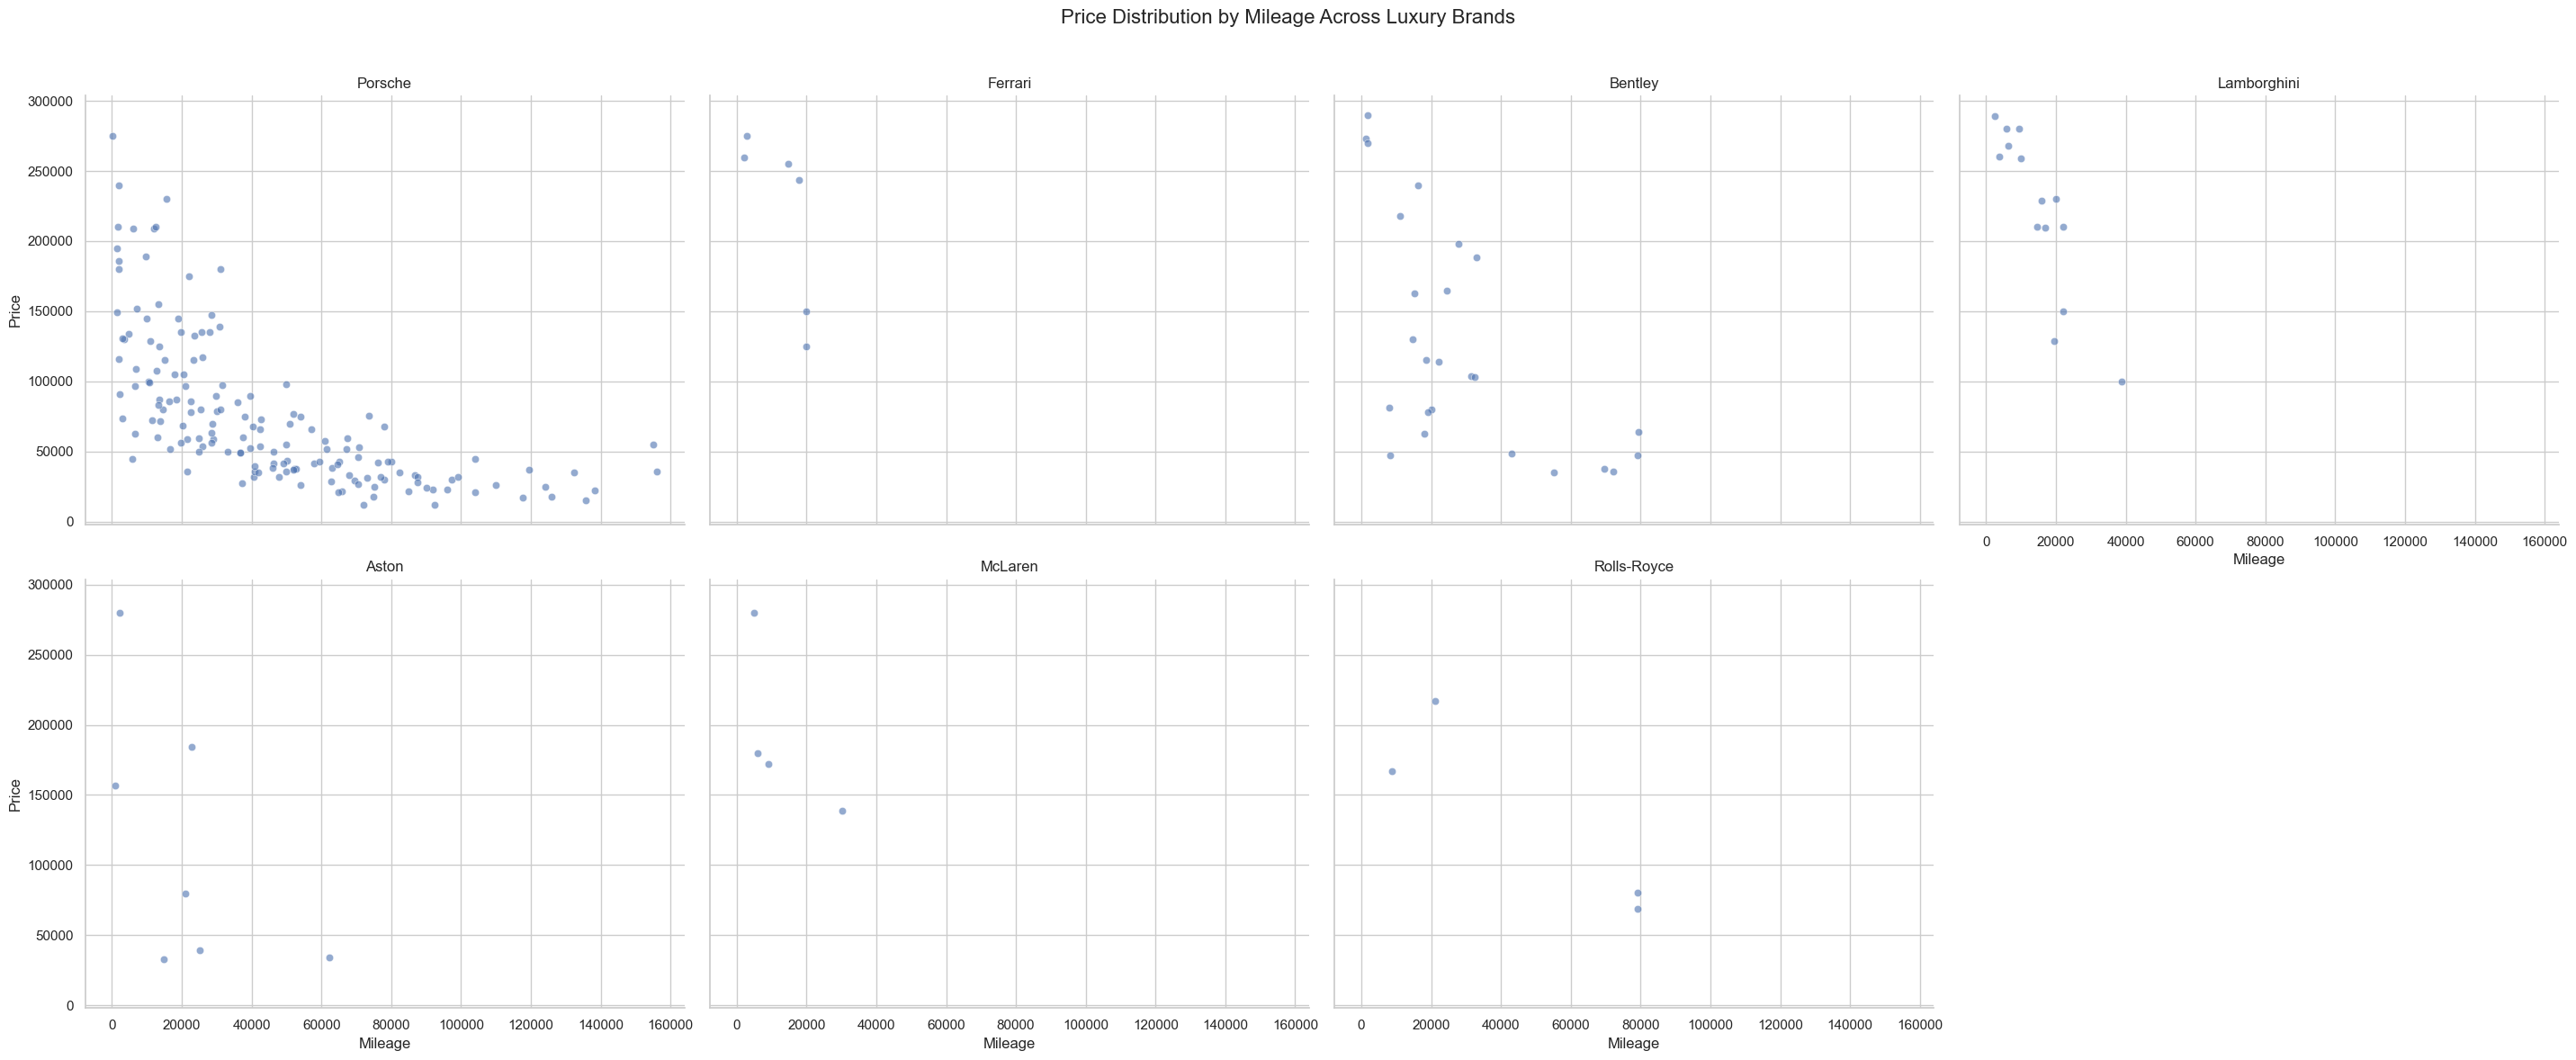

In [73]:
import seaborn as sns
import matplotlib.pyplot as plt

# Filter data to include only the specified brands
luxury_brands = ["Aston", "Bentley", "Porsche", "Lamborghini", "Ferrari", "McLaren", "Rolls-Royce"]
filtered_data = data_split[data_split["brand"].isin(luxury_brands)]

# Create the FacetGrid for Mileage vs Price
g = sns.FacetGrid(filtered_data, col="brand", col_wrap=4, height=6, aspect=1.2)
g.map_dataframe(sns.scatterplot, x="milage", y="price", alpha=0.6)

# Adjust labels and title
g.set_axis_labels("Mileage", "Price")
g.set_titles("{col_name}")
g.fig.subplots_adjust(top=0.9)  # Adjust top space
g.fig.suptitle("Price Distribution by Mileage Across Luxury Brands", fontsize=16)

# Show plot
plt.show()


Although, the correlations matrices (spearmann and pearson) indicate that brand isnt correlated with the price, we can see that it is still an important factor in dterming the price. For example, a vehicle with a milage of 40k from Toyota is priced from around 10k-70k, most of them being around 40k. Cars with the same milage of the brand Porsche, on the other hand, are around the 100-130k price tag. This is a difference of factor 2 to 3. Thus, we need to create attributes that differentiate these types of cars from the others so the model hopefully has a easier time determining car prices

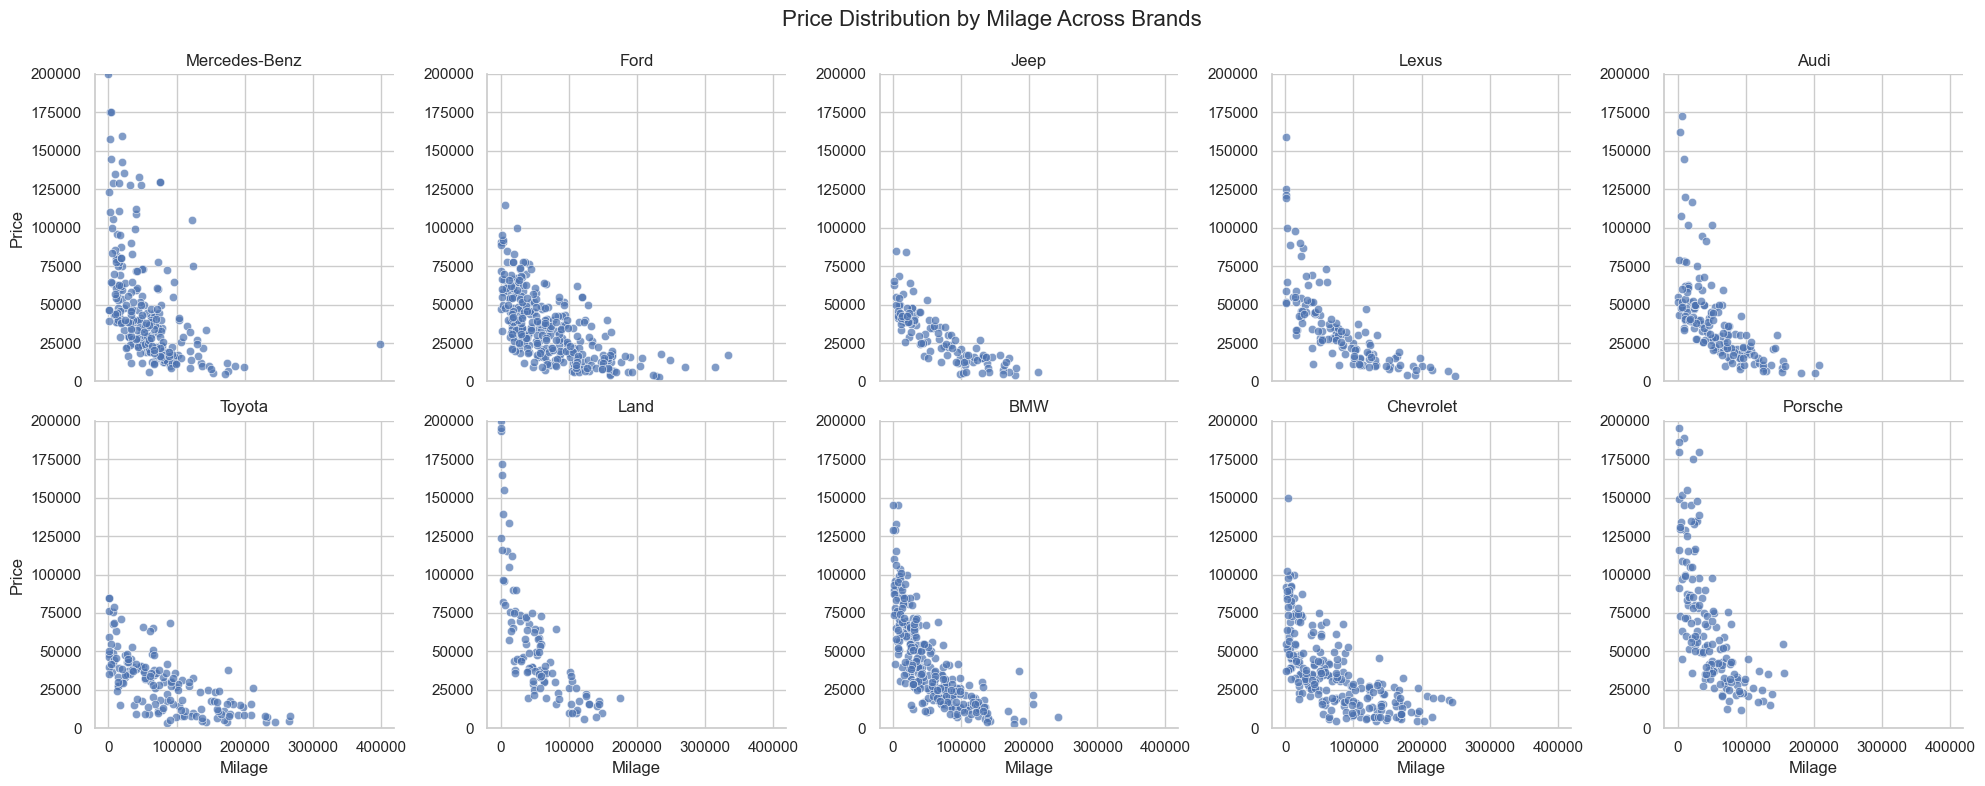

In [74]:
# Limit to top 10 brands and drop rows with missing prices
filtered_data = data_split.dropna(subset=['price'])
top_brands = filtered_data['brand'].value_counts().nlargest(10).index
filtered_data = filtered_data[filtered_data['brand'].isin(top_brands)]

# Create a FacetGrid
g = sns.FacetGrid(filtered_data, col="brand", col_wrap=5, height=4, sharey=False)
g.map_dataframe(sns.scatterplot, x="milage", y="price", alpha=0.7)

# Add titles and labels
g.set_axis_labels("Milage", "Price")
g.set_titles("{col_name}")
g.set(ylim=(0, 200000))
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle("Price Distribution by Milage Across Brands", fontsize=16)

plt.show()

The plot(s) shows that the value of cars is negativly impacted by the milage. However, some brands aren't as susceptible to this reducation as others. For example, 

In [75]:
data_split["age"] = 2024 - data_split["model_year"]

# Define the conditions and corresponding values
conditions = [
    data_split["is_luxury"] == 1,  # If is_luxury is 1
    data_split["is_upper_class"] == 1  # If is_upper_class is 1
]

# Define the corresponding values for each condition
values = [2, 1]  # 2 for is_luxury=1, 1 for is_upper_class=1

# Add the 'luxury_type' column based on the conditions
data_split["luxury_type"] = np.select(conditions, values, default=0)

data_split

,model_year,milage,accident,clean_title,price,turbo,is_luxury,is_upper_class,engine_score,brand,milage_Category,age,luxury_type
0,2000,194277.0,1,1,2300,0,0,0,-0.318,Nissan,>100k,24,0
1,2015,13300.0,0,1,62500,0,0,0,0.682,Mercedes-Benz,>10k<20k,9,0
2,2020,30426.0,1,0,29645,0,0,0,-0.454,GMC,>30k<40k,4,0
3,2020,67072.0,0,1,38500,0,0,0,0.136,Ford,>60k<70k,4,0
4,2016,99000.0,1,1,5000,0,0,0,-0.714,Jeep,>90k<100k,8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3198,2004,34254.0,0,1,64250,0,1,0,1.399,Maybach,>30k<40k,20,2
3199,2013,99982.0,1,1,6900,0,0,0,-0.829,Suzuki,>90k<100k,11,0
3200,1993,120644.0,0,1,4200,0,0,0,0.080,Mercury,>100k,31,0
3201,2021,31181.0,1,1,42442,0,0,0,-0.056,Buick,>30k<40k,3,0


Now lets compare the boxplot from earlier to boxplots filtered on the new features

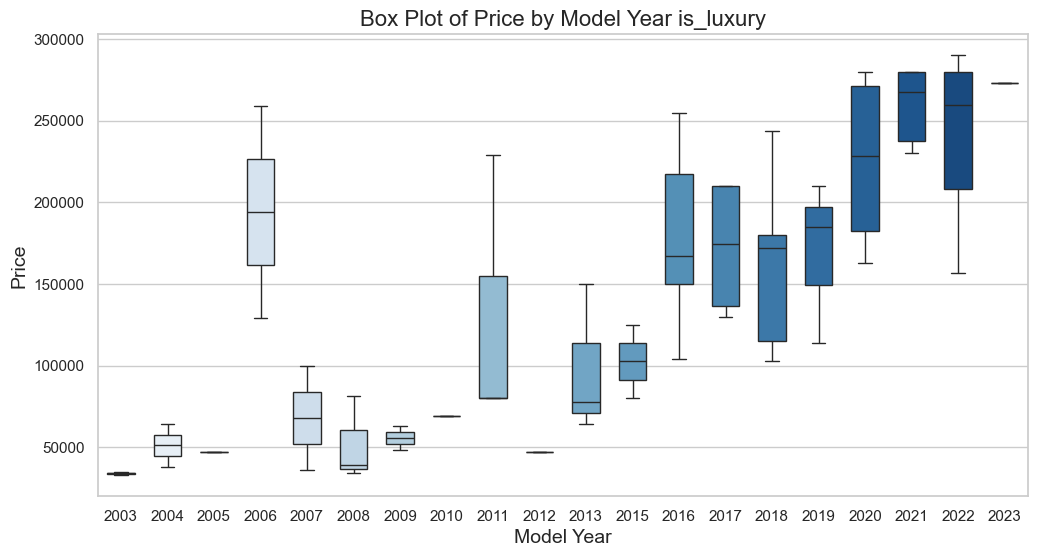

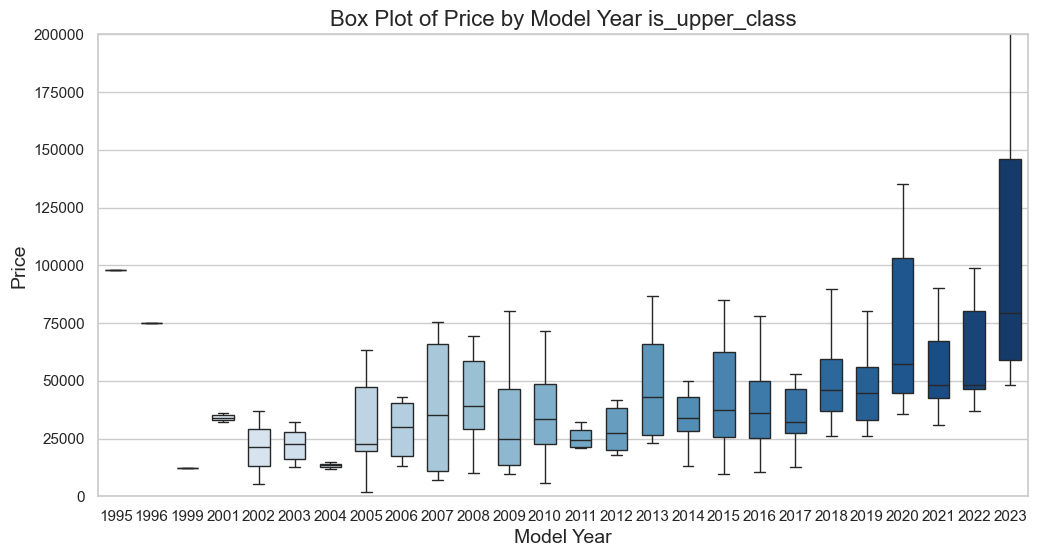

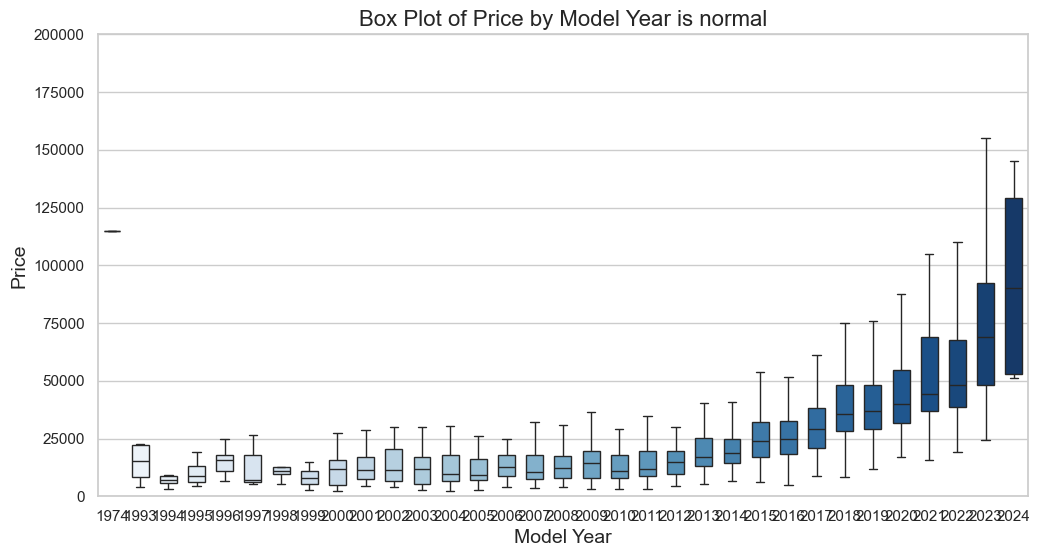

In [76]:
# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='model_year', y='price', data=data_split[data_split["is_luxury"] == 1], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=data_split, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by Model Year is_luxury', fontsize=16)
plt.xlabel('Model Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(data_split['model_year'].unique()), 5), labels=data_split['model_year'].unique()[::5])
plt.show()

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='model_year', y='price', data=data_split[data_split["is_upper_class"] == 1], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by Model Year is_upper_class', fontsize=16)
plt.xlabel('Model Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=train_set['model_year'].unique()[::5])
plt.ylim(0,200000)
plt.show()

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='model_year', y='price', data=data_split[(data_split["is_upper_class"] == 0) & (data_split["is_luxury"] == 0)], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by Model Year is normal', fontsize=16)
plt.xlabel('Model Year', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=train_set['model_year'].unique()[::5])
plt.ylim(0,200000)
plt.show()

There are large differences between the Box plots indicating that the seperation through the new attribute is helpful. When comparing the boxplot containing only normal cars with the plot with all, we can barely see a difference however. This can be explained by the number of cars represented by the class luxury or normal class. Since most of the cars are normal this leads to the box plot containing all cars converging with the one with only normal cars. 

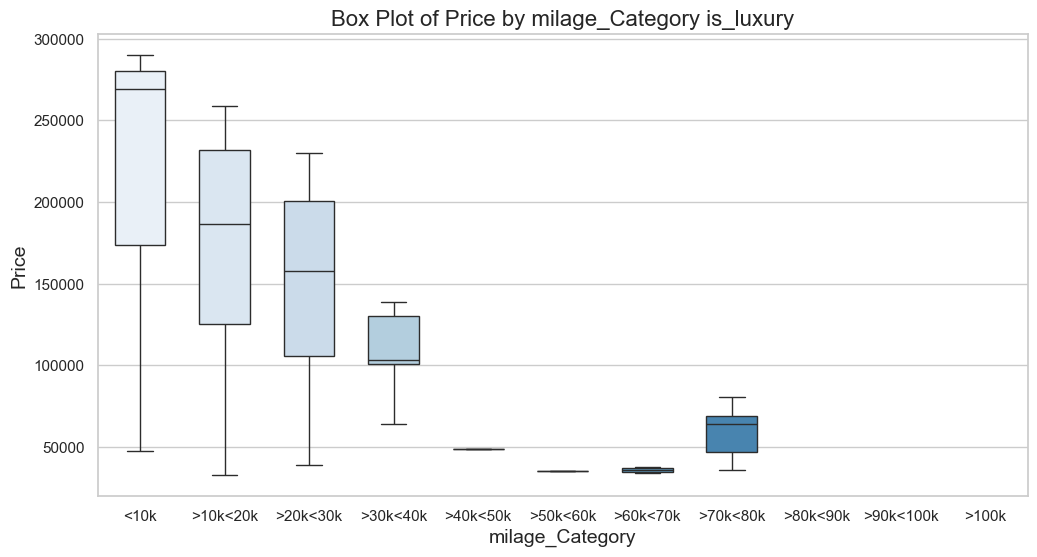

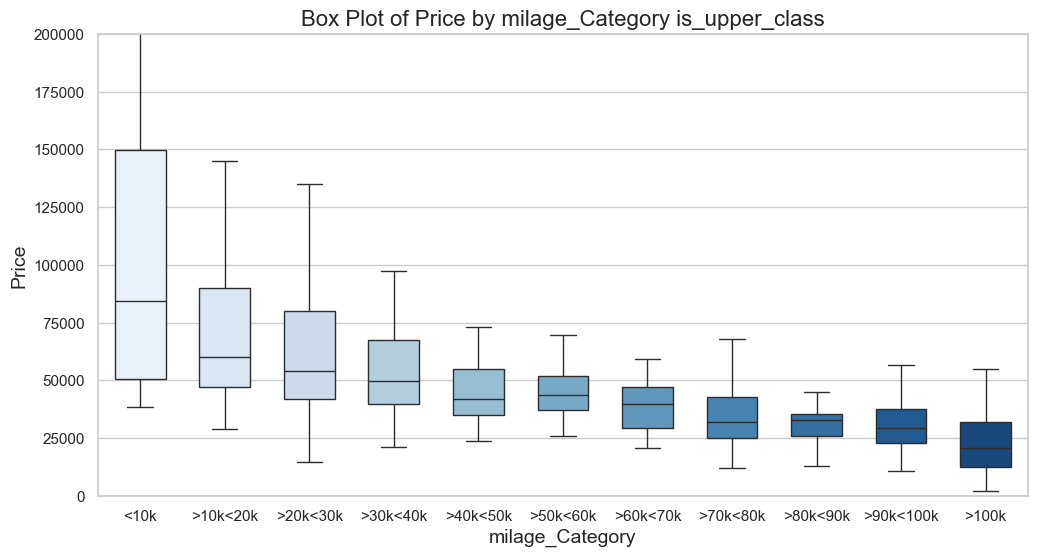

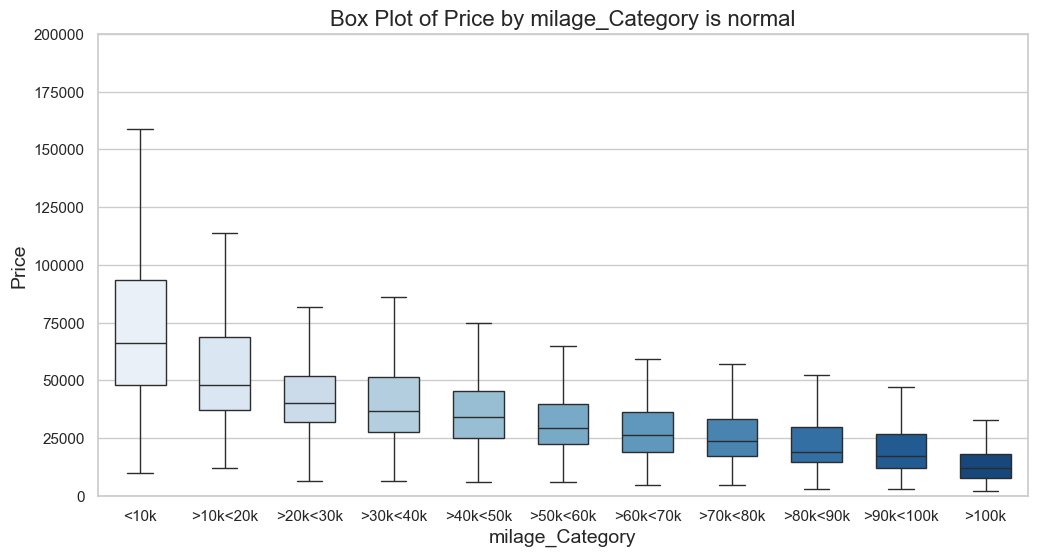

In [77]:
# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='milage_Category', y='price', data=data_split[data_split["is_luxury"] == 1], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by milage_Category is_luxury', fontsize=16)
plt.xlabel('milage_Category', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=train_set['model_year'].unique()[::5])
plt.show()

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='milage_Category', y='price', data=data_split[data_split["is_upper_class"] == 1], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by milage_Category is_upper_class', fontsize=16)
plt.xlabel('milage_Category', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=train_set['model_year'].unique()[::5])
plt.ylim(0,200000)
plt.show()

# Create the box plot
plt.figure(figsize=(12, 6))
sns.boxplot(x='milage_Category', y='price', data=data_split[(data_split["is_upper_class"] == 0) & (data_split["is_luxury"] == 0)], palette="Blues", width=0.6, fliersize=0)

# Overlay with a strip plot for individual points, colored by brand
# sns.stripplot(x='model_year', y='price', hue='brand', data=train_set, 
#               palette='Set2', dodge=True, jitter=True, size=8)

# Customize the plot
plt.title('Box Plot of Price by milage_Category is normal', fontsize=16)
plt.xlabel('milage_Category', fontsize=14)
plt.ylabel('Price', fontsize=14)
#plt.xticks(ticks=range(0, len(train_set['model_year'].unique()), 5), labels=data_split['model_year'].unique()[::5])
plt.ylim(0,200000)
plt.show()

# Checking the relevanz of Turbo

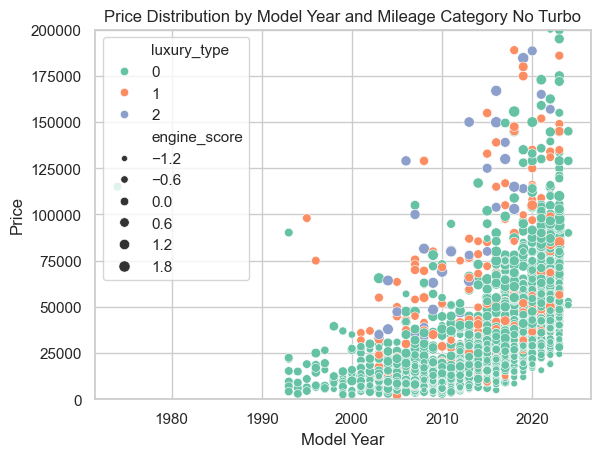

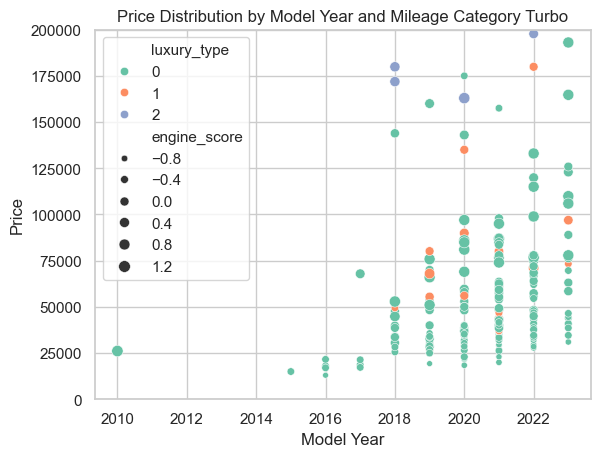

In [78]:


# Create the boxplot
sns.scatterplot(x='model_year', y='price', hue='luxury_type', size="engine_score", data=data_split[data_split["turbo"] == 0], palette="Set2")


# Add titles and labels
plt.title('Price Distribution by Model Year and Mileage Category No Turbo')
plt.xlabel('Model Year')
plt.ylabel('Price')
plt.ylim(0,200000)
plt.show()

# Create the boxplot
sns.scatterplot(x='model_year', y='price', hue='luxury_type', size="engine_score", data=data_split[data_split["turbo"] == 1], palette="Set2")


# Add titles and labels
plt.title('Price Distribution by Model Year and Mileage Category Turbo')
plt.xlabel('Model Year')
plt.ylabel('Price')
plt.ylim(0,200000)
plt.show()


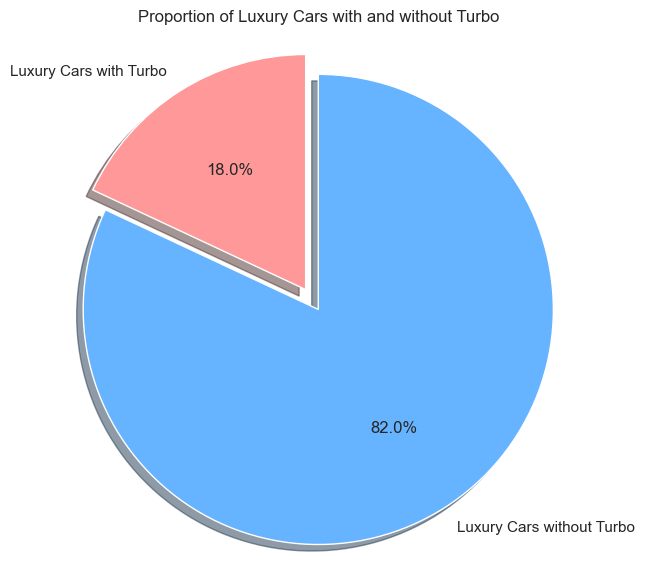

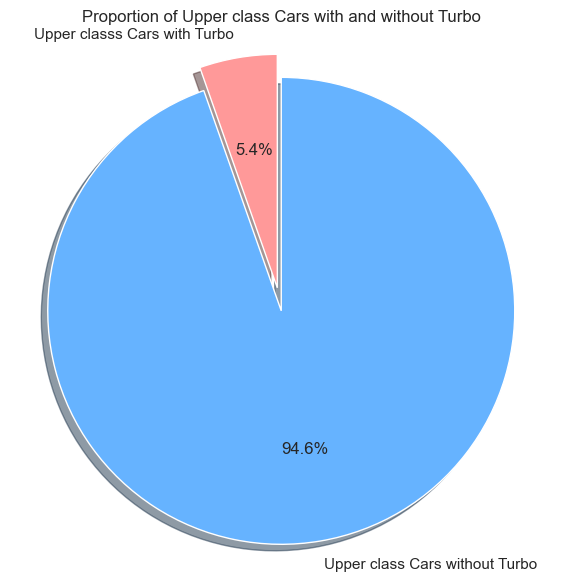

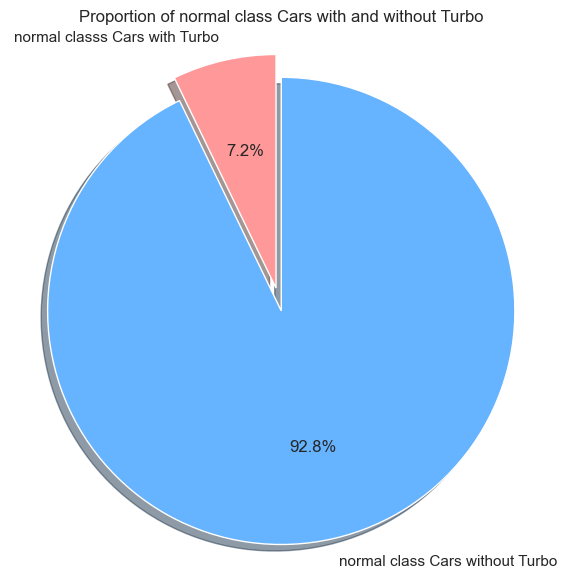

In [80]:
# Filter the data: Select only luxury cars containing turbo
luxury_turbo_cars = data_split[(data_split["is_luxury"] == 1) & (data_split["turbo"] == 1)]

# Count the total number of luxury cars and the number of luxury cars with turbo
total_luxury_cars = data_split[data_split["is_luxury"] == 1]
luxury_with_turbo = len(luxury_turbo_cars)
luxury_without_turbo = len(total_luxury_cars) - luxury_with_turbo

# Data for the pie chart
labels = ['Luxury Cars with Turbo', 'Luxury Cars without Turbo']
sizes = [luxury_with_turbo, luxury_without_turbo]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # explode 1st slice (Luxury Cars with Turbo)

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode, shadow=True)
plt.title('Proportion of Luxury Cars with and without Turbo')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()
#####################################################################################################################################################################
# Filter the data: Select only luxury cars containing turbo
luxury_turbo_cars = data_split[(data_split["is_upper_class"] == 1) & (data_split["turbo"] == 1)]

# Count the total number of luxury cars and the number of luxury cars with turbo
total_luxury_cars = data_split[data_split["is_upper_class"] == 1]
luxury_with_turbo = len(luxury_turbo_cars)
luxury_without_turbo = len(total_luxury_cars) - luxury_with_turbo

# Data for the pie chart
labels = ['Upper classs Cars with Turbo', 'Upper class Cars without Turbo']
sizes = [luxury_with_turbo, luxury_without_turbo]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # explode 1st slice (Luxury Cars with Turbo)

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode, shadow=True)
plt.title('Proportion of Upper class Cars with and without Turbo')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()

#####################################################################################################################################################################
# Filter the data: Select only luxury cars containing turbo
luxury_turbo_cars = data_split[(data_split["luxury_type"] == 0) & (data_split["turbo"] == 1)]

# Count the total number of luxury cars and the number of luxury cars with turbo
total_luxury_cars = data_split[data_split["luxury_type"] == 0]
luxury_with_turbo = len(luxury_turbo_cars)
luxury_without_turbo = len(total_luxury_cars) - luxury_with_turbo

# Data for the pie chart
labels = ['normal classs Cars with Turbo', 'normal class Cars without Turbo']
sizes = [luxury_with_turbo, luxury_without_turbo]
colors = ['#ff9999', '#66b3ff']
explode = (0.1, 0)  # explode 1st slice (Luxury Cars with Turbo)

# Create the pie chart
plt.figure(figsize=(7, 7))
plt.pie(sizes, labels=labels, autopct='%1.1f%%', startangle=90, colors=colors, explode=explode, shadow=True)
plt.title('Proportion of normal class Cars with and without Turbo')
plt.axis('equal')  # Equal aspect ratio ensures that pie chart is drawn as a circle.
plt.show()

Hypothesis: Int_Col has a surprising cor with price because expensive cars have a unique col (or unique color lead to more exp car). However, due to the scope of our paper we cannot examine what type of color is unique and if this leads to an more expensive car because the colors are too cryptic to differenitate it between expensive/unique color and normal. And for domain knowledge, we can assume that color doesnt have a signicifant impact on the price except if it is an extreme color like neon pink or so. However, due to the unlikehood of this being of higher importance than other essential factors like milage, HP or so, we wont conduct any further research on it.